In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import gaussian_kde
import cartopy.crs as ccrs
import xarray as xr
import glob
import datetime as dt
import tqdm
from matplotlib.patches import Rectangle
import pytz
from matplotlib.lines import Line2D
from cartopy import geodesic
import shapely
from matplotlib.patches import ConnectionPatch
from scipy.stats import genpareto, pareto
from scipy.stats.mstats import mquantiles
import scipy.stats
from sklearn.cluster import KMeans as kmeans

In [2]:
def plot_range_rings(lon, lat, r, ax, color="k", lw=1):

    circle_points = geodesic.Geodesic().circle(lon, lat, r*1000)
    geom = shapely.geometry.Polygon(circle_points)
    ax.add_geometries((geom,), crs=ccrs.PlateCarree(), facecolor='none', edgecolor=color, linewidth=lw, linestyle="-")    

def add_lt(df,tz):
    df["lt"] = df.index.tz_localize(pytz.utc).tz_convert(pytz.timezone(tz))
    return df

def load_scws(rid,tz):
    df1 = pd.read_csv("/g/data/eg3/ab4502/ExtremeWind/points/"+rid+"_scw_envs_df.csv")
    
    df1["cluster_new"] = df1.cluster.map({0:2,2:1,1:0})
    df1 = df1.set_index(pd.DatetimeIndex(df1.dt_utc))
    
    df1 = add_lt(df1,tz)    
        
    df1["year"] = df1.index.year
    df1["month"] = df1.index.month
    df1["hour"] = df1["lt"].dt.hour
    
    df1["rid"] = rid
    
    return df1

def remove_suspect_gusts(df):
    dts = ["2010-12-14 07:03:00","2011-01-11 03:49:00","2015-12-15 23:33:00","2020-02-09 01:00:00","2020-02-09 03:18:00","2020-05-25 06:11:00",
          "2012-11-02 18:58:00","2012-12-20 21:19:00","2012-12-15 13:00:00","2012-12-29 16:15:00","2012-12-30 06:25:00","2012-12-30 18:01:00","2013-01-02 08:15:00",
          "2013-01-05 03:36:00","2013-01-12 15:22:00","2013-02-11 07:56:00"]
    return df[np.in1d(df.dt_utc,dts,invert=True)]


def assign_storm_class(data):
    data["aspect_ratio"] = data.major_axis_length / data.minor_axis_length     
    #Linear
    data.loc[(data.aspect_ratio>=3) & (data.major_axis_length>=100),"class2"] = "Linear"
    #Non-linear
    data.loc[(data.aspect_ratio<3) & (data.major_axis_length>=100),"class2"] = "Non-linear"
    #Cellular
    data.loc[(data.local_max == 1),"class2"] = "Cellular"
    #Cluster of cells
    data.loc[(data.local_max>=2) & (data.major_axis_length<100),"class2"] = "Cell cluster"
    #Supercell
    data.loc[(data.max_alt>=7) & (data.azi_shear60>4) & ((data.aspect_ratio<3) | (data.major_axis_length<100)),"class2"] = "Supercellular"
    #Linear hybrid
    data.loc[(data.max_alt>=7) & (data.azi_shear60>4) & ((data.major_axis_length>=100)),"class2"] = "Embedded supercell"
    
    return data

In [3]:
tzs = {"68":'Australia/Melbourne',
       "64":'Australia/Adelaide',
       "8":'Australia/Brisbane',
       "72":'Australia/Queensland',
       "75":'Australia/Queensland',
       "19":'Australia/Queensland',
       "73":'Australia/Queensland',
       "78":'Australia/Queensland',
       "77":'Australia/Darwin',
       "49":'Australia/Victoria',
       "4":'Australia/Sydney',
       "40":'Australia/Canberra',
       "48":'Australia/West',
       "2":'Australia/Melbourne',
       "66":'Australia/Brisbane',
       "69":'Australia/NSW',
       "70":'Australia/Perth',
       "71":'Australia/Sydney',
      "63":'Australia/Darwin',
      "76":'Australia/Hobart',
      "77":"Australia/Darwin"}
       
rids = ["2","66","69","70","71","64","8","72","75","19","73","78","49","4","40","48","68","63","76","77"]
scws = [load_scws(rid,tzs[rid]) for rid in rids]
df_scw = remove_suspect_gusts(pd.concat(scws,axis=0))
print(str(df_scw.shape[0]) + " EVENTS")

413 EVENTS


/jobfs/69428262.gadi-pbs/ipykernel_1910784/2432529909.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clust["cluster"] = cluster_index
/jobfs/69428262.gadi-pbs/ipykernel_1910784/2432529909.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clust["cluster_new"] = df_clust.cluster.map({0:0,1:1,2:2})


0    151
1    139
2    123
Name: cluster_new, dtype: int64


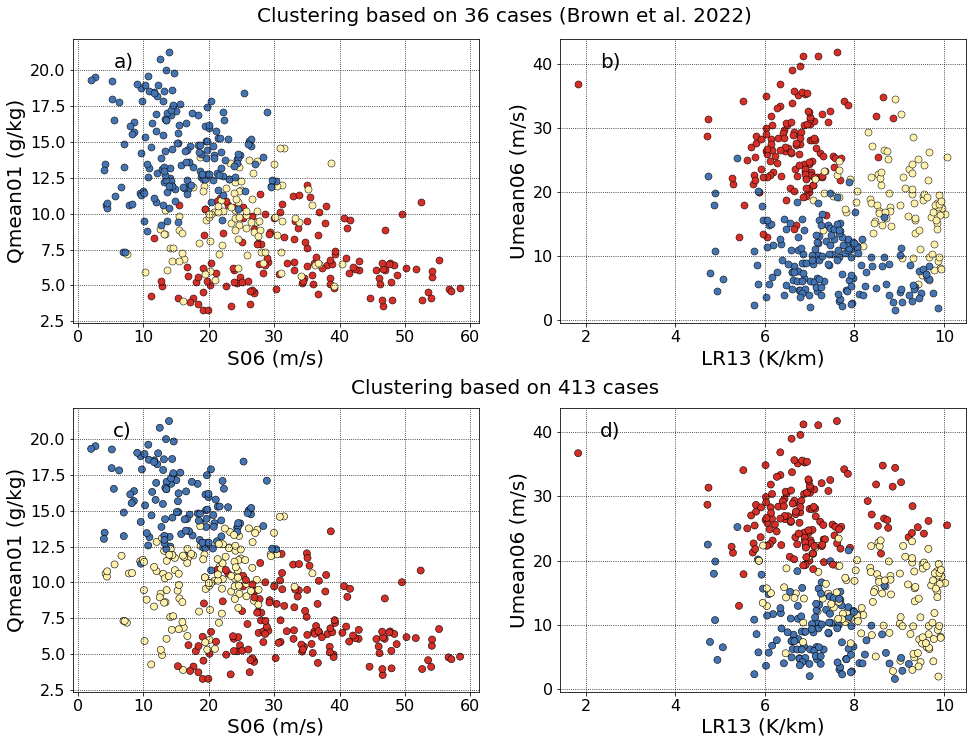

In [18]:
p=[plt.get_cmap("RdYlBu")(i) for i in [0.1,0.46,0.9]]
fig=plt.figure(figsize=[16,12])

plt.subplot(2,2,1)

plt.ylabel("Qmean01")
plt.xlabel("")


plt.scatter(df_scw.query("cluster_new==0").s06, df_scw.query("cluster_new==0").qmean01,color=p[0],marker="o",s=50,edgecolor="k",linewidths=0.5,
            label="Strong background wind cluster (N="+str(df_scw.query("cluster_new==0").shape[0])+")")
plt.scatter(df_scw.query("cluster_new==1").s06, df_scw.query("cluster_new==1").qmean01,color=p[1],marker="o",s=50,edgecolor="k",linewidths=0.5,
            label="Steep lapse rate cluster (N="+str(df_scw.query("cluster_new==1").shape[0])+")")
plt.scatter(df_scw.query("cluster_new==2").s06, df_scw.query("cluster_new==2").qmean01,color=p[2],marker="o",s=50,edgecolor="k",linewidths=0.5,
            label="High moisture cluster (N="+str(df_scw.query("cluster_new==2").shape[0])+")")
plt.gca().grid(color="k",ls=":")
plt.gca().tick_params("both",labelsize=16)
plt.gca().set_ylabel("Qmean01 (g/kg)",size=20)
plt.gca().set_xlabel("S06 (m/s)",size=20)
plt.gca().text(0.1,0.9,"a)",transform=plt.gca().transAxes,size=20)

#l=plt.legend(loc=8,fontsize=16,bbox_to_anchor=(1,-0.5),edgecolor="k")

plt.subplot(2,2,2)
plt.ylabel("")
plt.xlabel("")

plt.scatter(df_scw.query("cluster_new==0").lr13, df_scw.query("cluster_new==0").Umean06,color=p[0],marker="o",s=50,edgecolor="k",linewidths=0.5)
plt.scatter(df_scw.query("cluster_new==1").lr13, df_scw.query("cluster_new==1").Umean06,color=p[1],marker="o",s=50,edgecolor="k",linewidths=0.5)
plt.scatter(df_scw.query("cluster_new==2").lr13, df_scw.query("cluster_new==2").Umean06,color=p[2],marker="o",s=50,edgecolor="k",linewidths=0.5)
plt.gca().grid(color="k",ls=":")
plt.gca().tick_params("both",labelsize=16)
plt.gca().set_ylabel("Umean06 (m/s)",size=20)
plt.gca().set_xlabel("LR13 (K/km)",size=20)
plt.gca().text(0.1,0.9,"b)",transform=plt.gca().transAxes,size=20)




#Clusterin method based on all cases
var=["s06","qmean01","lr13","Umean06"]

df_clust = df_scw[var]
df_norm = (df_clust - df_clust.min(axis=0)) / (df_clust.max(axis=0) - df_clust.min(axis=0))


mod=kmeans(n_clusters=3, verbose=0, random_state=0)
mod_fit=mod.fit(df_norm[var])
cluster_index = mod_fit.predict(df_norm[var])

df_clust["cluster"] = cluster_index
df_clust["cluster_new"] = df_clust.cluster.map({0:0,1:1,2:2})

plt.subplot(2,2,3)
sns.scatterplot(data=df_clust,x="s06",y="qmean01",hue="cluster_new",
                palette=[plt.get_cmap("RdYlBu")(i) for i in [0.1,0.46,0.9]],
                edgecolor="k",legend=False, s=50)
plt.gca().grid(color="k",ls=":")
plt.gca().tick_params("both",labelsize=16)
plt.gca().set_ylabel("Qmean01 (g/kg)",size=20)
plt.gca().set_xlabel("S06 (m/s)",size=20)
plt.gca().text(0.1,0.9,"c)",transform=plt.gca().transAxes,size=20)

plt.subplot(2,2,4)
sns.scatterplot(data=df_clust,x="lr13",y="Umean06",hue="cluster_new",
                palette=[plt.get_cmap("RdYlBu")(i) for i in [0.1,0.46,0.9]],
               edgecolor="k",legend=False, s=50)
plt.gca().grid(color="k",ls=":")
plt.gca().tick_params("both",labelsize=16)
plt.gca().set_ylabel("Umean06 (m/s)",size=20)
plt.gca().set_xlabel("LR13 (K/km)",size=20)
plt.gca().text(0.1,0.9,"d)",transform=plt.gca().transAxes,size=20)

plt.subplots_adjust(hspace=0.3)
fig.text(0.5,0.47,"Clustering based on 413 cases", size=20, ha="center")
fig.text(0.5,0.90,"Clustering based on 36 cases (Brown et al. 2022)", size=20, ha="center")

print(df_clust.cluster_new.value_counts())

plt.savefig("/g/data/eg3/ab4502/ExtremeWind/systematic_clusters_test.jpeg",dpi=400,bbox_inches="tight")

100%|██████████| 9/9 [03:18<00:00, 22.08s/it]


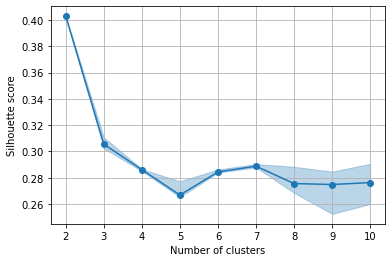

In [16]:
#Evaluate the clusters for ERA5 and BARRA

from sklearn import metrics

def fit_mod(df, var, random_state, n_clusters):
    mod=kmeans(n_clusters=n_clusters, verbose=0, random_state=random_state)
    mod_fit=mod.fit(df[var])
    cluster_index = mod_fit.predict(df[var])
    return mod_fit, cluster_index

sil_scores_mean = []
sil_scores_5 = []
sil_scores_95 = []
for n in tqdm.tqdm(np.arange(2,11)):    
    out = [fit_mod(df_norm, var, r, n) for r in np.arange(1000)]
    sils = [metrics.silhouette_score(df_norm, X[1]) for X in out]
    sil_scores_mean.append(np.mean(sils))
    sil_scores_5.append(np.percentile(sils,5))
    sil_scores_95.append(np.percentile(sils,95))   
    
plt.plot(np.arange(2,11), sil_scores_mean, marker="o", color="tab:blue", label="ERA5")
plt.fill_between(np.arange(2,11), sil_scores_5, sil_scores_95, alpha=0.3, color="tab:blue")

plt.ylabel("Silhouette score")
plt.xlabel("Number of clusters")
plt.gca().grid()    

<AxesSubplot:xlabel='cluster_new', ylabel='Umean06'>

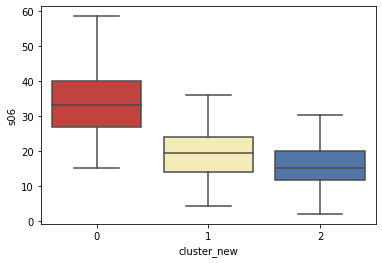

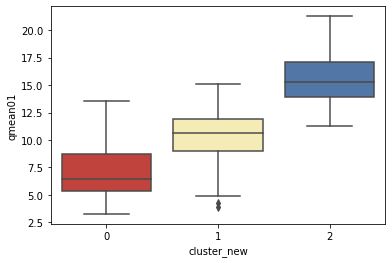

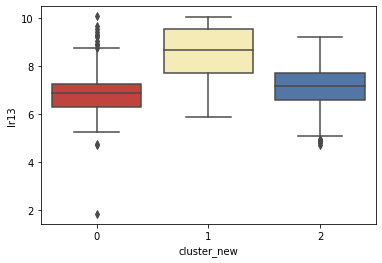

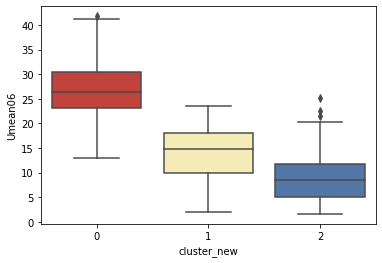

In [19]:
plt.figure()
sns.boxplot(data=df_clust,y="s06",x="cluster_new",
                palette=[plt.get_cmap("RdYlBu")(i) for i in [0.1,0.46,0.9]])

plt.figure()
sns.boxplot(data=df_clust,y="qmean01",x="cluster_new",
                palette=[plt.get_cmap("RdYlBu")(i) for i in [0.1,0.46,0.9]])

plt.figure()
sns.boxplot(data=df_clust,y="lr13",x="cluster_new",
                palette=[plt.get_cmap("RdYlBu")(i) for i in [0.1,0.46,0.9]])

plt.figure()
sns.boxplot(data=df_clust,y="Umean06",x="cluster_new",
                palette=[plt.get_cmap("RdYlBu")(i) for i in [0.1,0.46,0.9]])

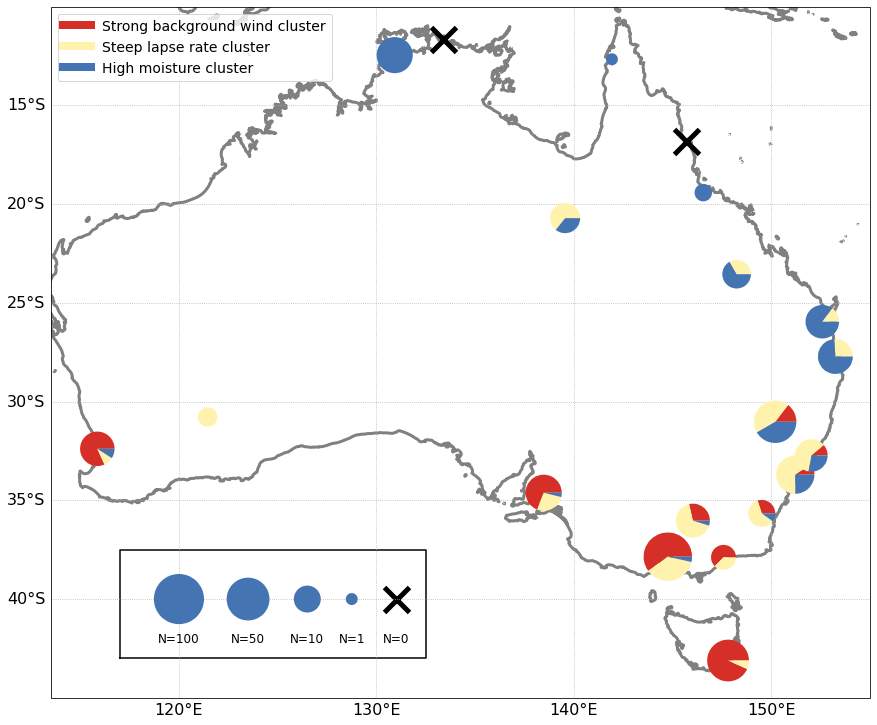

In [21]:
fig=plt.figure(figsize=[16,12])
ax0 = fig.add_axes([0.1,0.1,0.8,0.8],projection=ccrs.PlateCarree())
ax0.set_xlim([113.5,155])
ax0.set_ylim([-45,-10])
ax0.coastlines("10m",color="gray",lw=3)
g=ax0.gridlines(draw_labels=True,ylabel_style={"size":16},xlabel_style={"size":16},ls=":"); g.top_labels=False; g.right_labels=False

for rid in rids:
    f=xr.open_dataset(glob.glob("/g/data/rq0/level_2/"+rid+"/COLUMNMAXREFLECTIVITY/*.nc")[-1])
    lat0=f.attrs["origin_latitude"]
    lon0=f.attrs["origin_longitude"]   

    point = (lon0,lat0)
    trans = ax0.transData.transform(point)
    trans = ax0.transAxes.inverted().transform(trans)

    n_events = df_scw[df_scw.rid==rid].shape[0]
    #width_height = 0.08
    #width_height = n_events/153 * 0.1
    width_height = (np.log(n_events+2)/153) * 3
    
    if n_events > 0:
        ax1=ax0.inset_axes((trans[0]-(width_height/2),trans[1]-(width_height/2),
                            width_height,width_height),anchor="C")
        ax1.pie([(df_clust[df_scw.rid==rid].cluster_new == c).sum() for c in [0,1,2]],
               colors=p)
    else:
        ax0.plot(lon0,lat0,"x",color="k",ms=25,mew=5)

    

n_events = 100
point = (120,-40)
trans = ax0.transData.transform(point)
trans = ax0.transAxes.inverted().transform(trans)
width_height = (np.log(n_events+2)/153) * 3

ax1=ax0.inset_axes((trans[0]-(width_height/2),trans[1]-(width_height/2),
                    width_height,width_height),anchor="C")
ax1.pie([0,0,n_events],colors=p)
ax0.text(point[0],point[1]-2,"N=100",ha="center",va="center",size=12)

n_events = 50
point = (123.5,-40)
trans = ax0.transData.transform(point)
trans = ax0.transAxes.inverted().transform(trans)
width_height = (np.log(n_events+2)/153) * 3

ax1=ax0.inset_axes((trans[0]-(width_height/2),trans[1]-(width_height/2),
                    width_height,width_height),anchor="C")
ax1.pie([0,0,n_events],colors=p)
ax0.text(point[0],point[1]-2,"N=50",ha="center",va="center",size=12)

n_events = 10
point = (126.5,-40)
trans = ax0.transData.transform(point)
trans = ax0.transAxes.inverted().transform(trans)
width_height = (np.log(n_events+2)/153) * 3

ax1=ax0.inset_axes((trans[0]-(width_height/2),trans[1]-(width_height/2),
                    width_height,width_height),anchor="C")
ax1.pie([0,0,n_events],colors=p)
ax0.text(point[0],point[1]-2,"N=10",ha="center",va="center",size=12)

n_events = 1
point = (128.75,-40)
trans = ax0.transData.transform(point)
trans = ax0.transAxes.inverted().transform(trans)
width_height = (np.log(n_events+2)/153) * 3

ax1=ax0.inset_axes((trans[0]-(width_height/2),trans[1]-(width_height/2),
                    width_height,width_height),anchor="C")
ax1.pie([0,0,n_events],colors=p)
ax0.text(point[0],point[1]-2,"N=1",ha="center",va="center",size=12)

n_events = 0
point = (131,-40)
ax0.plot(point[0],point[1],marker="x",ms=25,mew=5,color="k")
ax0.text(point[0],point[1]-2,"N=0",ha="center",va="center",size=12)

ax0.plot([117,117,132.5,132.5,117],[-43,-37.5,-37.5,-43,-43],color="k")


custom_lines = [Line2D([0], [0], color=p[0], lw=8),
                Line2D([0], [0], color=p[1], lw=8),
                Line2D([0], [0], color=p[2], lw=8)]
plt.legend(custom_lines, ["Strong background wind cluster","Steep lapse rate cluster","High moisture cluster"], fontsize=14,loc=2)    

